In [1]:
#Mounting Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
## Install older opencv package for using sift features
!pip install opencv-python==3.4.10.37
!pip install opencv-contrib-python==3.4.10.37

In [39]:
#Importing Libraries
import os
import cv2
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import pylab as pl
import pandas as pd

from scipy.cluster.vq import kmeans, vq #vector quantization and kmeans clustering libraries
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
from sklearn.model_selection import KFold

In [4]:
import sys
import os, zipfile

#Unzipping the dataset
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Colab Notebooks/Computer Vision/Assignments/Assign_01/dataset.zip", "r")
zip_ref.extractall()
zip_ref.close()


## Utils

In [5]:
#Function to make it easy to list all file names in a directory
def imglist(path):    
    return [os.path.join(path, f) for f in os.listdir(path)]

In [6]:
# Getting paths to all images and saving them in a list image_paths
#And the corresponding labels being stored in image_classes list


def get_paths_labels(path, names):
  paths = []
  classes = []
  id = 0

  #Filling the placeholder empty lists with image path, classes, and assigning each class an ID number  
  for n in names:
    dir = os.path.join(path, n)
    p = imglist(dir)
    paths+=p
    classes+=[id]*len(p)
    id+=1 
  return paths, classes, id

In [7]:
# Now we need to create feature extraction and keypoint detector objects
def get_descriptors(paths):
  des_list = [] #Empty Descriptors list
  sift_ft = cv2.xfeatures2d.SIFT_create()  #SIFT for feature detection and descriptor Composition

  #Walking through every image and detecting the keypoints and computing the descriptors and strong them in a list
  for i in paths:
    im = cv2.imread(i)
    kpts, des = sift_ft.detectAndCompute(im, None)
    des_list.append((i, des))   

  # Stacking all the descriptors vertically in a numpy array
  descriptors = des_list[0][1]
  for image_path, descriptor in des_list[1:]:
    descriptors = np.vstack((descriptors, descriptor)) 

  return (des_list, descriptors) 


In [8]:
def get_feature_clusters(descriptors):
  #converting descriptor integers to float as kmeans required float
  descriptors_float = descriptors.astype(float)  

  k = 300  #kmeans clusters chosen tentatively
  voc, variance = kmeans(descriptors_float, k, 1) 

  return k, voc, variance

In [9]:
def get_usable_feature_vectors(image_paths, k, des_list, voc):
  #histogram of features and their vector represention
  #vq Assigns codes from a code book to observations.
  im_features = np.zeros((len(image_paths), k), "float32")
  for i in range(len(image_paths)):
    words, distance = vq(des_list[i][1],voc)
    for w in words:
        im_features[i][w] += 1
  # Perform Tf-Idf vectorization
  #Term frequency-inverse document frequency is a text vectorizer that transforms the text into a usable vector
  #freq = np.sum( (im_features > 0) * 1, axis = 0)
  #feature_vector = np.array(np.log((1.0*len(image_paths)+1) / (1.0*freq + 1)), 'float32')
  

  return im_features

In [10]:
def feature_standardization (features):
  #Standardize features by removing the mean and scaling to unit variance
  stdScalar = StandardScaler().fit(features)
  std_features = stdScalar.transform(features)

  return stdScalar, std_features


In [11]:
def plotHistogram(im_features, no_clusters):
    x_scalar = np.arange(no_clusters)
    y_scalar = np.array([abs(np.sum(im_features[:,h], dtype=np.int32)) for h in range(no_clusters)])

    plt.bar(x_scalar, y_scalar)
    plt.xlabel("Visual Word Index")
    plt.ylabel("Frequency")
    plt.title("Complete Vocabulary Generated")
    plt.xticks(x_scalar + 0.4, x_scalar)
    plt.show()

In [12]:
def svmClass (features, classes, names, stdSlr, k, voc):
  (X_train, X_test, y_train, y_test)= train_test_split(features, classes, test_size=0.10, random_state=123)
  # Training the Linear SVM for classification
  model = LinearSVC(max_iter=10000)
  #clf.fit(features, np.array(classes))
   
  kf = KFold(n_splits=7, shuffle=True, random_state=123) 
  #saving SVM and bovw trained model
  #joblib.dump((clf, names, stdSlr, k, voc), "/content/drive/MyDrive/Colab Notebooks/Computer Vision/Assignments/Assign_01/SVMbovw.pkl", compress=3)  


  val_score = []
  train_time=[]
  inf_time=[]

  i=1
  for train_index , test_index in kf.split(X_train):
    start = time.time()
    X_tr , X_val =[ X_train[i,:] for i in train_index],[X_train[i,:] for i in test_index]
    y_tr , y_val = [y_train[i] for i in train_index] , [y_train[i] for i in test_index]

    y_tr=y_tr
    y_val=y_val 
    model.fit(X_tr,y_tr)
    tr_t= time.time() - start 
    train_time.append(tr_t)
    joblib.dump(model, '/content/drive/MyDrive/Colab Notebooks/Computer Vision/Assignments/Assign_01/SVMbovw'+ str(i) +'.pkl', compress=1)

    s_it=time.time()
    pred_values = model.predict(X_val)
    e_it=time.time()-s_it
    inf_time.append(e_it)

    val = accuracy_score(pred_values , y_val)
    
    print('Val accuracy of model {} - {}'.format(i,val))
    val_score.append(val)
    i+=1

  avg_val_score = sum(val_score)/7
  print('Avg Val accuracy for SVM : {}'.format(avg_val_score))
  print('Training Time for SVM: {}' .format(sum(train_time)/k))
  print('Inference Time for SVM: {}' .format(sum(inf_time)/k)) 

  max_value = max(val_score)
  max_index = val_score.index(max_value)

  model = joblib.load('/content/drive/MyDrive/Colab Notebooks/Computer Vision/Assignments/Assign_01/SVMbovw'+str(max_index+1)+'.pkl') 
  joblib.dump((model, names, stdSlr, k, voc), "/content/drive/MyDrive/Colab Notebooks/Computer Vision/Assignments/Assign_01/SVMFinal.pkl", compress=3) 


In [13]:
def RFClass (features, classes, names, stdSlr, k, voc):

  (X_train, X_test, y_train, y_test)= train_test_split(features, classes, test_size=0.10, random_state=123)
  # Training the RF for classification
  model = RandomForestClassifier(n_estimators = 200, random_state=30)
  #clf.fit(features, np.array(classes))
   

  kf = KFold(n_splits=7, shuffle=True, random_state=123) 
  #saving SVM and bovw trained model
  #joblib.dump((clf, names, stdSlr, k, voc), "/content/drive/MyDrive/Colab Notebooks/Computer Vision/Assignments/Assign_01/SVMbovw.pkl", compress=3)  


  val_score = []
  train_time=[]
  inf_time=[]

  i=1
  for train_index , test_index in kf.split(X_train):
    start = time.time()
    X_tr , X_val =[ X_train[i,:] for i in train_index],[X_train[i,:] for i in test_index]
    y_tr , y_val = [y_train[i] for i in train_index] , [y_train[i] for i in test_index]

    y_tr=y_tr
    y_val=y_val 
    model.fit(X_tr,y_tr)
    tr_t= time.time() - start 
    train_time.append(tr_t)
    joblib.dump(model, '/content/drive/MyDrive/Colab Notebooks/Computer Vision/Assignments/Assign_01/RFbovw'+ str(i) +'.pkl', compress=1)

    s_it=time.time()
    pred_values = model.predict(X_val)
    e_it=time.time()-s_it
    inf_time.append(e_it)

    val = accuracy_score(pred_values , y_val)
    
    print('Val accuracy of model {} - {}'.format(i,val))
    val_score.append(val)
    i+=1

  avg_val_score = sum(val_score)/7
  print('Avg Val accuracy for RF : {}'.format(avg_val_score))
  print('Training Time for RF: {}' .format(sum(train_time)/k))
  print('Inference Time for RF: {}' .format(sum(inf_time)/k)) 

  max_value = max(val_score)
  max_index = val_score.index(max_value)

  model = joblib.load('/content/drive/MyDrive/Colab Notebooks/Computer Vision/Assignments/Assign_01/RFbovw'+str(max_index+1)+'.pkl') 
  joblib.dump((model, names, stdSlr, k, voc), "/content/drive/MyDrive/Colab Notebooks/Computer Vision/Assignments/Assign_01/RFFinal.pkl", compress=3) 



In [14]:
def MLPClass (features, classes, names, stdSlr, k, voc):

  (X_train, X_test, y_train, y_test)= train_test_split(features, classes, test_size=0.10, random_state=123)
  # Training the MLP for classification
  model = MLPClassifier(hidden_layer_sizes=(100, 100), activation="relu")
  #clf.fit(features, np.array(classes))
   
  kf = KFold(n_splits=7, shuffle=True, random_state=123) 
  #saving SVM and bovw trained model
  #joblib.dump((clf, names, stdSlr, k, voc), "/content/drive/MyDrive/Colab Notebooks/Computer Vision/Assignments/Assign_01/SVMbovw.pkl", compress=3)  


  val_score = []
  train_time=[]
  inf_time=[]

  i=1
  for train_index , test_index in kf.split(X_train):
    start = time.time()
    X_tr , X_val =[ X_train[i,:] for i in train_index],[X_train[i,:] for i in test_index]
    y_tr , y_val = [y_train[i] for i in train_index] , [y_train[i] for i in test_index]

    y_tr=y_tr
    y_val=y_val 
    model.fit(X_tr,y_tr)
    tr_t= time.time() - start 
    train_time.append(tr_t)
    joblib.dump(model, '/content/drive/MyDrive/Colab Notebooks/Computer Vision/Assignments/Assign_01/MLPbovw'+ str(i) +'.pkl', compress=1)

    s_it=time.time()
    pred_values = model.predict(X_val)
    e_it=time.time()-s_it
    inf_time.append(e_it)

    val = accuracy_score(pred_values , y_val)
    
    print('Val accuracy of model {} - {}'.format(i,val))
    val_score.append(val)
    i+=1

  avg_val_score = sum(val_score)/7
  print('Avg Val accuracy for MLP : {}'.format(avg_val_score))
  print('Training Time for MLP: {}' .format(sum(train_time)/k))
  print('Inference Time for MLP: {}' .format(sum(inf_time)/k)) 

  max_value = max(val_score)
  max_index = val_score.index(max_value)

  model = joblib.load('/content/drive/MyDrive/Colab Notebooks/Computer Vision/Assignments/Assign_01/MLPbovw'+str(max_index+1)+'.pkl') 
  joblib.dump((model, names, stdSlr, k, voc), "/content/drive/MyDrive/Colab Notebooks/Computer Vision/Assignments/Assign_01/MLPFinal.pkl", compress=3) 




In [56]:
def evaluate_model(test_features, image_classes, classes_names):
    p=pd.DataFrame()
    #Report true class names so they can be compared with predicted classes
    true_class =  [classes_names[i] for i in image_classes]
    test_score = []
    for m in range(1,8):
       clf = joblib.load('/content/drive/MyDrive/Colab Notebooks/Computer Vision/Assignments/Assign_01/RFbovw'+str(m)+'.pkl') 
       # Perform the predictions and report predicted class names. 
       pred =  [classes_names[i] for i in clf.predict(test_features)]
       p[m]=pred
    
    predictions=[]

    for ind in p.index:
      t=[]
      for m in range(1,8):
        t.append(p[m][ind])
      pp=max(set(t), key = t.count)  
      predictions.append(pp)
    

    #Print the true class and Predictions 
    print ("true_class ="  + str(true_class))
    print ("prediction ="  + str(predictions))
    accuracy = accuracy_score(true_class, predictions)
    print ("accuracy = ", accuracy)
    


    cm = confusion_matrix(true_class, predictions)
    print (cm)

    plt.figure(figsize=(8,8))
    sns.heatmap(cm, annot=True, fmt='g')
    plt.xticks(np.arange(cm.shape[0]), ['00001', '000010', '00002', '00003', '00004', '00005', '00006', '00007', '00008', '00009'], rotation=90)
    plt.yticks(np.arange(cm.shape[0]), ['00001', '000010', '00002', '00003', '00004', '00005', '00006', '00007', '00008', '00009'], rotation=0)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    
    false_positives = cm.sum(axis=0) - np.diag(cm)  
    false_negatives = cm.sum(axis=1) - np.diag(cm)
    true_positives = np.diag(cm)
    true_negatives = cm.sum() - (false_positives + false_negatives + true_positives)
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = true_positives/(true_positives+false_negatives)
    # Specificity or true negative rate
    TNR = true_negatives/(true_negatives+false_positives) 
    # Precision or positive predictive value
    PPV = true_positives/(true_positives+false_positives)
    # Negative predictive value
    NPV = true_negatives/(true_negatives+false_negatives)
    # Fall out or false positive rate
    FPR = false_positives/(false_positives+true_negatives)
    # False negative rate
    FNR = false_negatives/(true_positives+false_negatives)
    # False discovery rate
    FDR = false_positives/(true_positives+false_positives)

    # Overall accuracy
    ACC = (true_positives+true_negatives)/(true_positives+false_positives+false_negatives+true_negatives)

    print("True positive rate for each class: ",TPR)
    print("False positive rate for each class: ",FPR)

    ## Precision and recall and f-1 score for positive class
    precision = float(true_positives[1]) / (true_positives[1] + false_positives[1])
    recall = float(true_positives[1]) / (true_positives[1] + false_negatives[1])

    f1 = 2*precision*recall / (precision + recall)

    print ("Precision: " + str(precision))
    print("Recall: " + str(recall))
    print ("F1 Score: " + str(f1))

    return true_class, predictions

## Training

In [16]:
# We need to get the classes' names and store them in a list
#Folder names will be used as class names

train_path = 'dataset/Train'  #Training path
training_names = os.listdir(train_path)    # Classes are 00001-000010
training_names.sort()

In [17]:
training_names

['00001',
 '000010',
 '00002',
 '00003',
 '00004',
 '00005',
 '00006',
 '00007',
 '00008',
 '00009']

In [18]:
image_paths, image_classes, class_id = get_paths_labels(train_path, training_names) #Gettig paths, classes and Ids for training images

In [19]:
np.unique(image_classes)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [20]:
des_list, descriptors=get_descriptors(image_paths) #Getting descriptors

In [21]:
k, voc, variance = get_feature_clusters(descriptors)  #descriptors/features clustering

In [22]:
im_features=get_usable_feature_vectors(image_paths, k, des_list, voc) #image features after clustering

In [23]:
# Training the models for classification
stdScalar, std_features= feature_standardization(im_features)
svmClass(im_features, image_classes, training_names, stdScalar, k, voc)
RFClass(im_features, image_classes, training_names, stdScalar, k, voc)
MLPClass(im_features, image_classes, training_names, stdScalar, k, voc)

Val accuracy of model 1 - 0.8446601941747572
Val accuracy of model 2 - 0.8737864077669902
Val accuracy of model 3 - 0.8155339805825242
Val accuracy of model 4 - 0.8543689320388349
Val accuracy of model 5 - 0.8446601941747572
Val accuracy of model 6 - 0.8640776699029126
Val accuracy of model 7 - 0.8235294117647058
Avg Val accuracy for SVM : 0.8458023986293546
Training Time for SVM: 0.0019495177268981933
Inference Time for SVM: 2.317190170288086e-05
Val accuracy of model 1 - 0.9029126213592233
Val accuracy of model 2 - 0.883495145631068
Val accuracy of model 3 - 0.912621359223301
Val accuracy of model 4 - 0.883495145631068
Val accuracy of model 5 - 0.8737864077669902
Val accuracy of model 6 - 0.9029126213592233
Val accuracy of model 7 - 0.8823529411764706
Avg Val accuracy for RF : 0.891653748878192
Training Time for RF: 0.012615896066029867
Inference Time for RF: 0.0008676767349243164
Val accuracy of model 1 - 0.8446601941747572
Val accuracy of model 2 - 0.8932038834951457
Val accuracy o

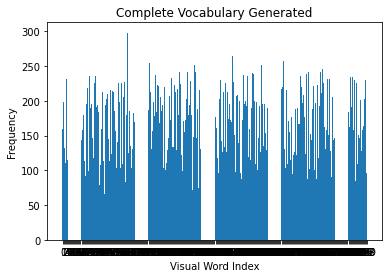

In [24]:
plotHistogram(std_features,k)

## Testing 

In [48]:
#Loading saved classification model
clf, classes_names, stdSlr, k, voc = joblib.load("/content/drive/MyDrive/Colab Notebooks/Computer Vision/Assignments/Assign_01/RFFinal.pkl")

In [26]:
classes_names

['00001',
 '000010',
 '00002',
 '00003',
 '00004',
 '00005',
 '00006',
 '00007',
 '00008',
 '00009']

In [49]:
test_path = '/content/dataset/Test' 

In [50]:
# We need to get the classes' names and store them in a list
#Folder names will be used as class names
testing_names = os.listdir(test_path)
testing_names.sort()

In [51]:
testing_names

['0001',
 '00010',
 '0002',
 '0003',
 '0004',
 '0005',
 '0006',
 '0007',
 '0008',
 '0009']

In [52]:
image_paths, image_classes, class_id = get_paths_labels(test_path, testing_names) #Gettig paths, classes and Ids for testing images

In [53]:
des_list, descriptors=get_descriptors(image_paths) #getting test image descriptors

In [54]:
im_features=get_usable_feature_vectors(image_paths, k, des_list, voc) #no clustering for test images

true_class =['00001', '00001', '00001', '00001', '00001', '00001', '00001', '00001', '00001', '00001', '00001', '00001', '00001', '00001', '00001', '00001', '00001', '00001', '00001', '00001', '000010', '000010', '000010', '000010', '000010', '000010', '000010', '000010', '000010', '000010', '000010', '000010', '000010', '000010', '000010', '000010', '000010', '000010', '000010', '000010', '00002', '00002', '00002', '00002', '00002', '00002', '00002', '00002', '00002', '00002', '00002', '00002', '00002', '00002', '00002', '00002', '00002', '00002', '00002', '00002', '00003', '00003', '00003', '00003', '00003', '00003', '00003', '00003', '00003', '00003', '00003', '00003', '00003', '00003', '00003', '00003', '00003', '00003', '00003', '00003', '00004', '00004', '00004', '00004', '00004', '00004', '00004', '00004', '00004', '00004', '00004', '00004', '00004', '00004', '00004', '00004', '00004', '00004', '00004', '00004', '00005', '00005', '00005', '00005', '00005', '00005', '00005', '000

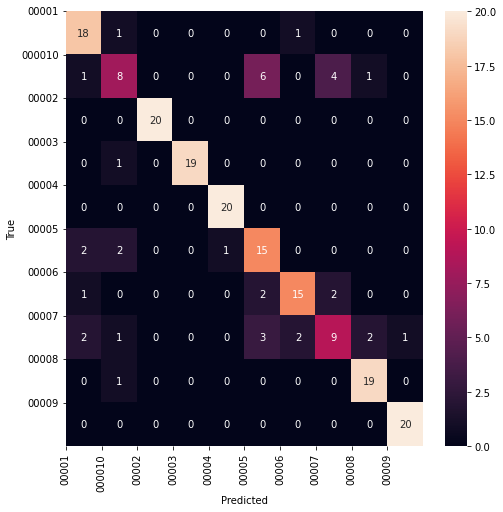

True positive rate for each class:  [0.9  0.4  1.   0.95 1.   0.75 0.75 0.45 0.95 1.  ]
False positive rate for each class:  [0.03333333 0.03333333 0.         0.         0.00555556 0.06111111
 0.01666667 0.03333333 0.01666667 0.00555556]
Precision: 0.5714285714285714
Recall: 0.4
F1 Score: 0.47058823529411764


In [57]:
# Scale the features
#Standardize features by removing the mean and scaling to unit variance
#Scaler (stdSlr comes from the pickled file we imported)
test_features = stdSlr.transform(im_features)

#Predicting the test images class and Evaluating the results 
true_class, predictions= evaluate_model(test_features, image_classes, classes_names)



## Qualitative Results

Showing correct predictions
{96, 197, 136, 105, 45, 177, 82, 119, 29}


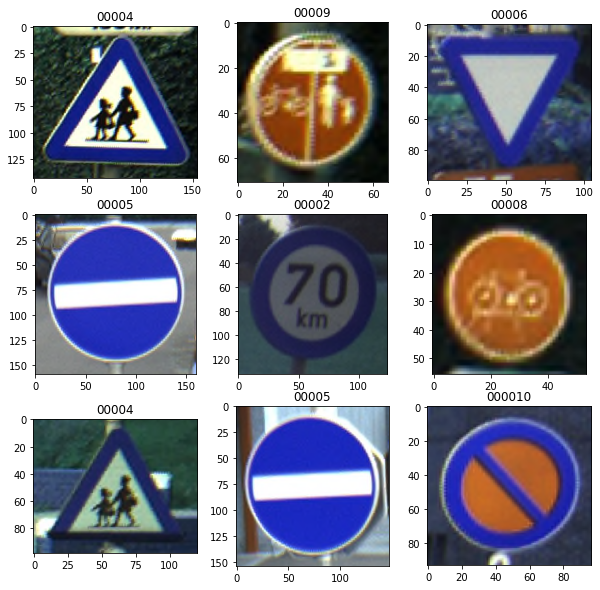

Showing wrong predictions
{33, 2, 132, 137, 140, 148, 23, 154, 158}


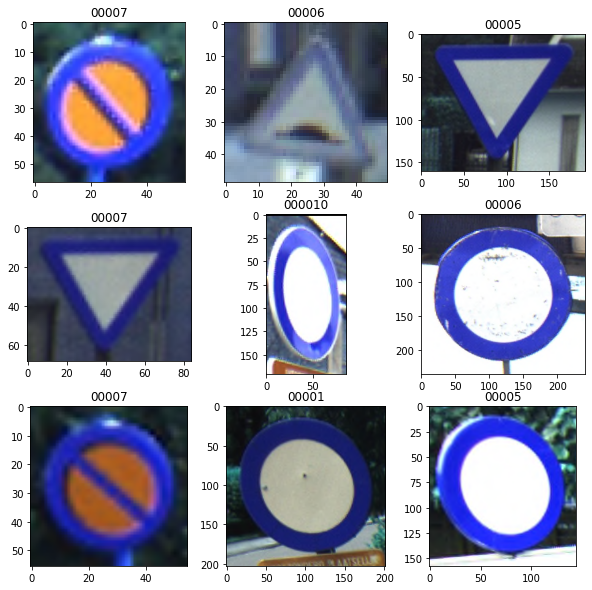

In [34]:
#Seperating indices for correctly and incorrectly predicted samples
correct_preds = np.array(true_class) == np.array(predictions)
correct_inds, incorrect_inds = [],[]

for i,x in enumerate(correct_preds):
  if x:
    correct_inds.append(i)
  else:
    incorrect_inds.append(i)

#choose random correct and incorrect samples
correct_inds = set(np.random.choice(correct_inds, size=9))
incorrect_inds = set(np.random.choice(incorrect_inds, size=9))


print("Showing correct predictions")
print(correct_inds)
imgs, labels = [], []
for i,x in enumerate(correct_inds):
  imgs.append(cv2.imread(image_paths[x]))
  labels.append(predictions[x])
_, axs = plt.subplots(3, 3, figsize=(10, 10))
axs = axs.flatten()
for img, ax, l in zip(imgs, axs, labels):
    ax.imshow(img)
    ax.set_title(l)
plt.show()


print("Showing wrong predictions")
print(incorrect_inds)
imgs, labels = [], []
for i,x in enumerate(incorrect_inds):
  imgs.append(cv2.imread(image_paths[x]))
  labels.append(predictions[x])
_, axs = plt.subplots(3, 3, figsize=(10, 10))
axs = axs.flatten()
for img, ax, l in zip(imgs, axs, labels):
   ax.imshow(img)
   ax.set_title(l)
plt.show()